# CSC 2621 Final Project
**Authors:**  Thomas Benzshawel, Lucas Gral, Ben Paulson<Br/>
Section 131

[Associated GitHub Repository](https://github.com/ThomasBenzshawel/dasci-final)

[Associated Presentation Link](https://msoe365-my.sharepoint.com/:p:/g/personal/benzshawelt_msoe_edu/EWkYlq08PrZJo2wi0vCZnZ8B92eyS7vgOyK56dRwD4Ze7g?e=A6op41)

# Introduction

Lab about determining sentiment of Steam reviews.

TODO TODO TODOTODO TODO TODOTODO TODO TODOTODO TODO TODOTODO TODO TODOTODO TODO TODOTODO TODO TODOTODO TODO TODOTODO TODO TODOTODO TODO TODOTODO TODO TODOTODO TODO TODOTODO TODO TODOTODO TODO TODOTODO TODO TODO

In [1]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import matplotlib.pyplot as plt
nltk.download('stopwords')
nltk.download('punkt')
from collections import defaultdict
from sklearn.model_selection import train_test_split
import torch
from transformers import BertModel, BertTokenizer
import os
import csv

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\benzshawelt\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\benzshawelt\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Part 1: Data Exploration

### Part 1a: Data Importing & Description
The main dataset that will be used throughout this analysis is https://www.kaggle.com/datasets/andrewmvd/steam-reviews/code. This dataset contains 6.4 million reviews from the Steam platform; users are only able to review the game if they have bought and played the game. The reviews are from 2014 to 2017. The dataset contains the following columns: `app_id`, `app_name`, `review_text`, `review_score`, `review_votes`. The definition for each column is as follows:
* **app_id**: Unique ID of the game
* **app_name**: Name of the game
* **review_text**: Text of the review
* **review_score**: Score of the review (1 is positive, -1 is negative)
* **review_votes**: Number of votes the review received for 'helpfulness'

In this dataset, there are 6,417,106 reviews, reviewing 9,363 unique games. The average review score is 0.6395, meaning the average review of these 9,363 games is a positive review. The average review vote score is 0.147, meaning the community does not identify most reviews as being helpful by at least one person. Also, the average number of characters per review is 304, with the smallest being 1 and the largest being 8,873. Also, interestingly, there are over 8,000 reviews which are single-character, with "." being the most popular at 4,885 reviews.

In this dataset, there are 631 games with ratings of 100% based on the reviews given (which is a subset of the total reviews on Steam)

The datatypes of each of the different columns is as follows:
|id|Column|Dtype|
|---|---|---|
 0|app_id|int64 
 1|app_name|object
 2|review_text|object
 3|review_score|int64 
 4|review_votes|int64 

**memory usage:** 244.8+ MB

In [2]:
review_data = pd.read_csv("dataset.csv")
review_data.head()

,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,Ruined my life.,1,0
1,10,Counter-Strike,This will be more of a ''my experience with th...,1,1
2,10,Counter-Strike,This game saved my virginity.,1,0
3,10,Counter-Strike,• Do you like original games? • Do you like ga...,1,0
4,10,Counter-Strike,"Easy to learn, hard to master.",1,1


In [3]:
review_data.columns

Index(['app_id', 'app_name', 'review_text', 'review_score', 'review_votes'], dtype='object')

### Part 1b: Importing Genre Data Using NLP to get the Genre of Each Game

In [4]:
genre_data = pd.read_csv("steam_game_genre_manual_clean.csv")
genre_data.drop(columns=['number_of_reviews'], inplace=True)
genre_data.drop(columns=['Unnamed--0'], inplace=True)
genre_data.drop(columns=['review_score'], inplace=True)
genre_data.shape

(9857, 2)

In [5]:
genre_data_cleaned = genre_data.drop_duplicates(subset=['app_name'])

In [6]:
genre_data_cleaned.shape

(9363, 2)

Here we can clearly see that we reduced the number of roes by 14, removing that many duplicate entries

In [7]:
genre_data_cleaned.head()

,app_name,answer
0,Discovering Colors - Animals,Educational
1,Fabric,Puzzle
2,Trigonarium,Arcade
3,Aveyond 3-3: The Lost Orb,RPG
4,Aveyond 3-4: The Darkthrop Prophecy,RPG


### Exploration 1: Average Review Score by Game
**Intro:** Group the dataset by game and calculate the average review score for each game within this dataset. Also get a count for the number of reviews for each game.

**Conclusion:** TODO TDOO TDOO TDOO T

In [8]:
# Get the average review_score for each unique app_name
df = review_data[['app_name', 'review_score']].groupby('app_name').mean().reset_index().sort_values(by='review_score', ascending=False).reset_index(drop=True)

# Add a column called number_of_reviews to the dataframe
df['number_of_reviews'] = review_data[['app_name', 'review_score']].groupby('app_name').count().reset_index()['review_score']
df

,app_name,review_score,number_of_reviews
0,Discovering Colors - Animals,1.0,14
1,Fabric,1.0,26
2,Trigonarium,1.0,103
3,Aveyond 3-3: The Lost Orb,1.0,27
4,Aveyond 3-4: The Darkthrop Prophecy,1.0,63
...,...,...,...
9358,Angle of Attack,-1.0,2
9359,Retool,-1.0,1
9360,Ke-Tsu-No-Ana,-1.0,5
9361,3D Sprite Renderer and Convex Hull Editor,-1.0,190


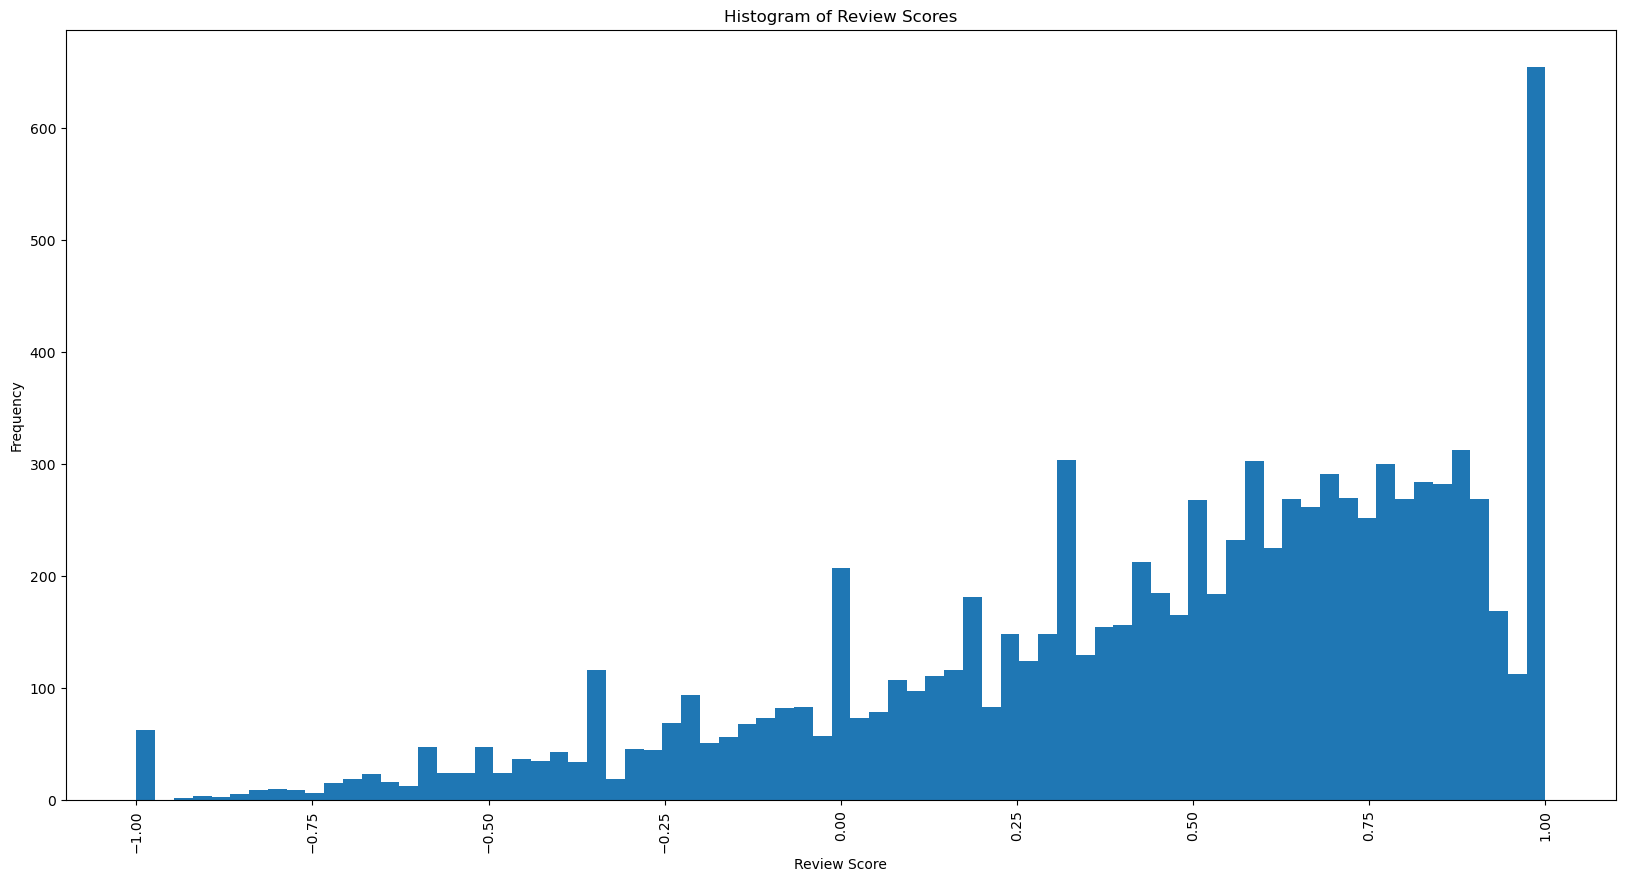

In [9]:
# Plot a bar chart of the review_score for each app_name
plt.figure(figsize=(20, 10))
plt.hist(df['review_score'], bins = 75)
plt.xticks(rotation=90)
plt.xlabel('Review Score')
plt.ylabel('Frequency')
plt.title('Histogram of Review Scores')
plt.show()

### Exploration 2: Early Access Reviews
**Intro:** TODO TDOO TDOO TDOO T

**Conclusion:** TODO TDOO TDOO TDOO T

In [ ]:
BEN PAULSON

In [ ]:
early_access_data = review_data.apply(lambda x: True if x[''] == True else False , axis=1)

### Exploration 3: Term Frequency for Positive/Negative Reviews

(THOMAS)

### Using our stop word cleaning function

In [23]:
stopwords_list = set(stopwords.words('english'))

def remove_stop_words(text, stopwords):
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stopwords]
    return " ".join(filtered_sentence)

review_data_no_stopwords = review_data['review_text'].apply(lambda x: remove_stop_words(str(x), stopwords_list))

In [24]:
review_data_no_stopwords.head()

0                                        Ruined life .
1    This `` experience game '' type review , sayin...
2                          This game saved virginity .
3    • Do like original games ? • Do like games n't...
4                           Easy learn , hard master .
Name: review_text, dtype: object

In [25]:
review_data["stopwords_removed"] = review_data_no_stopwords

In [26]:
review_data.head()

,app_id,app_name,review_text,review_score,review_votes,stopwords_removed
0,10,Counter-Strike,Ruined my life.,1,0,Ruined life .
1,10,Counter-Strike,This will be more of a ''my experience with th...,1,1,"This `` experience game '' type review , sayin..."
2,10,Counter-Strike,This game saved my virginity.,1,0,This game saved virginity .
3,10,Counter-Strike,• Do you like original games? • Do you like ga...,1,0,• Do like original games ? • Do like games n't...
4,10,Counter-Strike,"Easy to learn, hard to master.",1,1,"Easy learn , hard master ."


In [10]:
review_data_and_genre = pd.merge(review_data, genre_data_cleaned, on='app_name')
review_data_and_genre.rename(columns={"answer": "genre"}, inplace=True)

In [11]:
review_data_and_genre.head()

,app_id,app_name,review_text,review_score,review_votes,genre
0,10,Counter-Strike,Ruined my life.,1,0,Shooter
1,10,Counter-Strike,This will be more of a ''my experience with th...,1,1,Shooter
2,10,Counter-Strike,This game saved my virginity.,1,0,Shooter
3,10,Counter-Strike,• Do you like original games? • Do you like ga...,1,0,Shooter
4,10,Counter-Strike,"Easy to learn, hard to master.",1,1,Shooter


In [43]:
genre_dict = defaultdict(list)
def count_words_in_genre(genre_dict, genre, text):
    word_tokens = word_tokenize(text)
    for word in word_tokens:
        genre_dict[genre].append(word)
    return genre_dict

In [44]:
updated_genre_dict = review_data_and_genre.apply(lambda x: count_words_in_genre(genre_dict, x['genre'], x['stopwords_removed']), axis=1)

### Part 1 Conclusion

# Part 2: Cleaning & Preprocessing


### Part 2a: Cleaning for Supervised Learning Models

In [ ]:
# Cleaning 
Lucas Gral

In [ ]:
# Division for x and y in preparation for sentiment analysis training

### Part 2b: Cleaning for Clustering

In [ ]:
# Cleaning
# Done already


In [ ]:
# Division for x and y in preparation for genre-classification training
train_test_split(review_data_and_genre, test_size=0.2, random_state=42)

# Part 3: Statistical Analysis
For this section _________________________________________________

We will utilize an alpha-value ($\alpha$) of 0.05 for all statistical tests.

**MUST CLEAR UP:** A sampling greater than 30 should be sufficient for a normal distribution, but it does not appear like we actually have a normal distribution. We should review the central limit theorm. Also, we should review the distributions we are making to ensure that we are not making any mistakes.

**BEN PAULSON**

### Part 3a: Chi-Squared Independence Test for Genre & Review Score
**Hypothesis:** (Adopt standard null hypothesis for Chi-squared test)

### Part 3b: Test of Correlation Between Review Score & Review Length
**Hypothesis:** 

### Part 3c: Test of Correlation Between Review Length & Review Helpfulness
**Hypothesis:** 

# Part 4: Sentiment Analysis Experiments (Supervised Models)

### Part 4a: KKN w/ tfidf
Using the labels (positivity/negativity)

In [ ]:
LUCAS GRAL

### Part 4b: Fine-Tuning BERT
Using the labels (positivity/negativity), a BERT model will be fine-tuned

In [ ]:
LUCAS GRAL

# Part 5: Sentiment Analysis Experiments (Clustering)

### Part 3a: K-Means Clustering
BERT Embeddings

In [12]:
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True,)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

100%|██████████| 231508/231508 [00:00<00:00, 2062702.06B/s]


In [25]:
def bert_text_preparation(text, tokenizer):
    """
    Preprocesses text input in a way that BERT can interpret.
    """
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    tokenized_text = tokenized_text[0:512]
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1]*len(indexed_tokens)
    
    # convert inputs to tensors
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensor = torch.tensor([segments_ids])
    
    return tokenized_text, tokens_tensor, segments_tensor

In [26]:
def get_bert_embeddings(tokens_tensor, segments_tensor, model):
    """
    Obtains BERT embeddings for tokens.
    """
    # gradient calculation is disabled
    with torch.no_grad():
        # obtain hidden states
        outputs = model(tokens_tensor, segments_tensor)
        hidden_states = outputs[2]    # concatenate the tensors for all layers
    # use "stack" to create new dimension in tensor
    token_embeddings = torch.stack(hidden_states, dim=0)    # remove dimension 1, the "batches"
    token_embeddings = torch.squeeze(token_embeddings, dim=1)    # swap dimensions 0 and 1 so we can loop over tokens
    token_embeddings = token_embeddings.permute(1,0,2)    # intialized list to store embeddings
    token_vecs_sum = []    # "token_embeddings" is a [Y x 12 x 768] tensor
    # where Y is the number of tokens in the sentence    
    # loop over tokens in sentence
    for token in token_embeddings:    # "token" is a [12 x 768] tensor    
        # sum the vectors from the last four layers
        sum_vec = torch.sum(token[-4:], dim=0)
        token_vecs_sum.append(sum_vec)
        
    return token_vecs_sum

In [29]:
from collections import OrderedDict

context_embeddings = []
context_tokens = []
for sentence in review_data['review_text'].head(10):
    tokenized_text, tokens_tensor, segments_tensors = bert_text_preparation(sentence, tokenizer)
    list_token_embeddings = get_bert_embeddings(tokens_tensor, segments_tensors, model)  # make ordered dictionary to keep track of the position of each   word
    tokens = OrderedDict()  # loop over tokens in sensitive sentence
    
    for token in tokenized_text[1:-1]:
        # keep track of position of word and whether it occurs multiple times
        if token in tokens:
            tokens[token] += 1
        else:
            tokens[token] = 1  # compute the position of the current token
        token_indices = [i for i, t in enumerate(tokenized_text) if t == token]
        current_index = token_indices[tokens[token]-1]  # get the corresponding embedding
        token_vec = list_token_embeddings[current_index]

        # save values
        context_tokens.append(token)
        context_embeddings.append(token_vec)

In [32]:
filepath = os.path.join('')
name = 'metadata_small.tsv'

with open(os.path.join(filepath, name), 'w+') as file_metadata:
    for i, token in enumerate(context_tokens):
        file_metadata.write(token + '\n')
        name = 'embeddings_small.tsv'
        
        with open(os.path.join(filepath, name), 'w+') as tsvfile:
            writer = csv.writer(tsvfile, delimiter='\t')
            for embedding in context_embeddings:
                writer.writerow(embedding.numpy())

# Visualizing the embedding in TensorBoard
https://projector.tensorflow.org/

### Part 3b: K-Means Clustering
Term Frequency Space

In [ ]:
THOMAS BENZSHAWEL

# Part 6: Evaluation

### Part 6a: Evaluating Supervised Models

In [ ]:
LUCAS GRAL

### Part 6b: Evaluating Clustering Models

In [ ]:
THOMAS BENZSHAWEL

# Conclusion
TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO TODO TDOO TDODO 

# Contribution Statement
* **Lucas Gral:**
* **Thomas Benzshawel:**
* **Ben Paulson:**